## Prelude

In [132]:
import random as rd
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import linear_model
from sklearn.preprocessing import Imputer
import matplotlib.pyplot as plt
%matplotlib notebook
# import scipy.stats as sps
# import datetime as dt
# import matplotlib.dates as mdates

In [ ]:
# read original data save to a faster format
df = pd.read_csv('properties_2016.csv', low_memory=False)
df.to_pickle('properties_2016.pkl')

I found reading csv so slow (20 seconds? don't want to bother again), so being able to store the data in an efficient format is such a charm. The cell above should be executed only once.

In [158]:
# initialize
df = pd.read_pickle('properties_2016.pkl')

In [159]:
# cleaning

# delete entries where room number = 0, not realistic
roomcnts = [col for col in df if 'roomcnt' in col]
df[roomcnts] = df[roomcnts].replace(0.0, np.nan)

# turn AC and heating type into numericals
heat = df.loc[:,['heatingorsystemtypeid']]
heat[heat == 13] = 0; heat[heat > 0] = 1
df['heatingorsystemtypeid'] = heat['heatingorsystemtypeid']
ac = df.loc[:,['airconditioningtypeid']]
ac[ac == 5] = 0; ac[ac > 0] = 1
df['airconditioningtypeid'] = ac['airconditioningtypeid']

# drop empty records(rows)
df.dropna(thresh=2, inplace=True)

# drop columns with 95% missing
df.drop([col for col in df if df[col].count() / df.shape[0] < 0.05], axis=1, inplace=True)

# drop columns with almost constant value
df.drop([col for col in df if df[col].value_counts().size == 1], axis=1, inplace=True)

## Task 1: Heatmap

In [18]:
corrmat = df.corr()

<IPython.core.display.Javascript object>


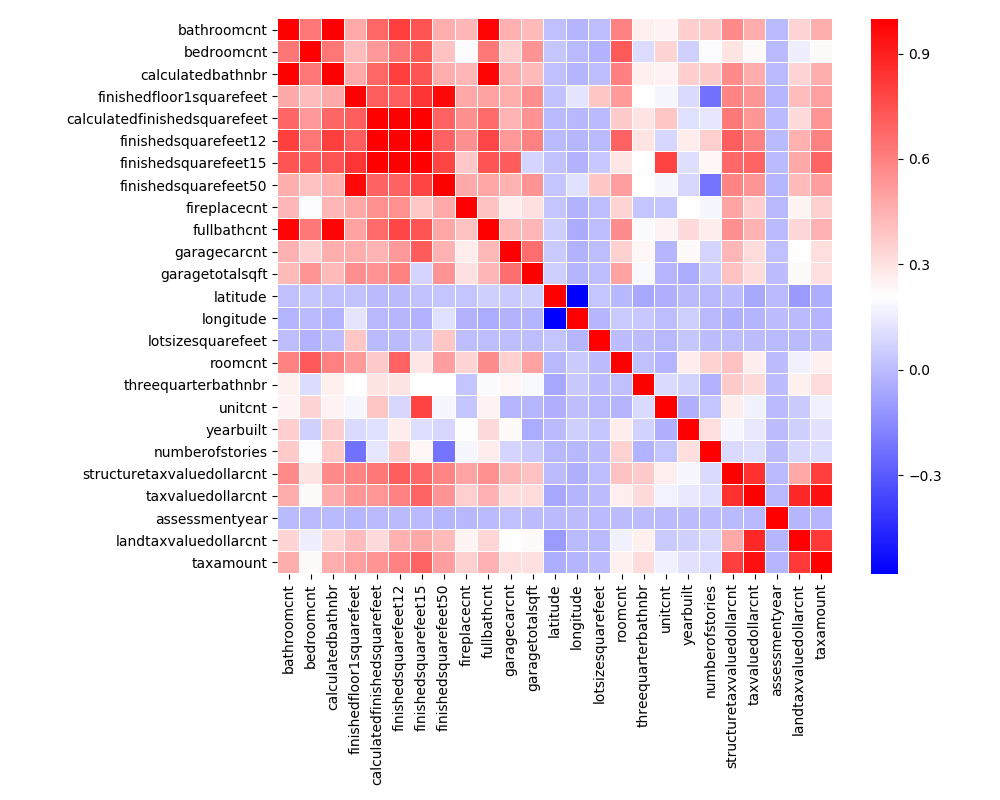

In [30]:
# plt.rc('figure', figsize=(10, 8))
plt.subplots()
sns.heatmap(corrmat, cmap='bwr', xticklabels=True, yticklabels=True, linewidths=0.1, square=True)
plt.yticks(rotation=0);
plt.xticks(rotation=90);
plt.tight_layout()
plt.show()

## Task 2: Plots

This section provides plots of either a single feature or a pair of features. Description and analysis are attached below each figure.

### Plot 1 & 2: Histogram

<IPython.core.display.Javascript object>


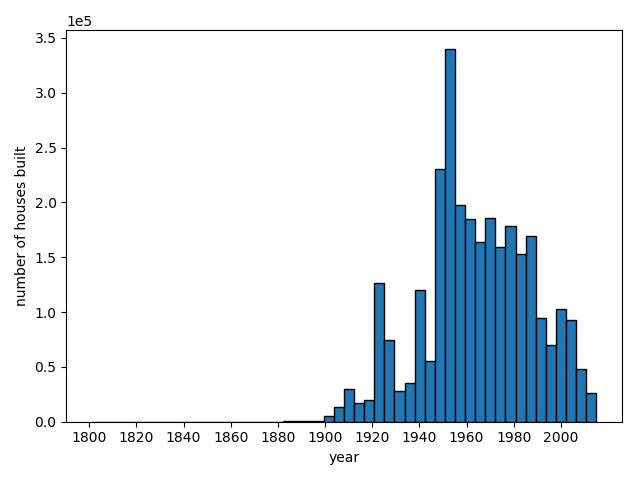

<IPython.core.display.Javascript object>


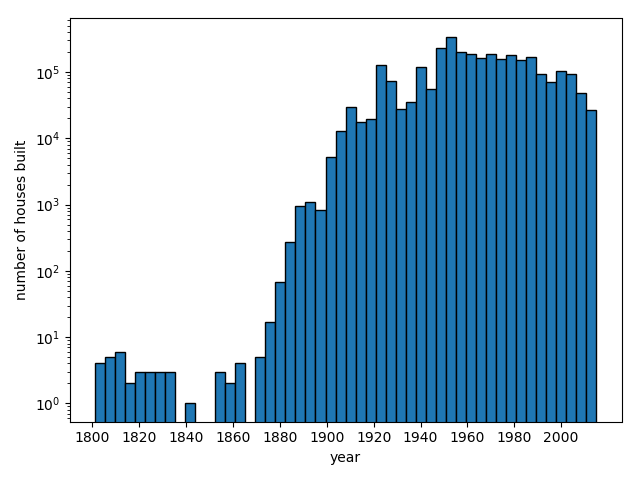

In [247]:
x = 'yearbuilt'; y = 'number of houses built'
plt.subplots()
plt.hist(df[x].dropna(), bins=50, range=(1801, 2015), ec='k')
plt.xlabel('year'); plt.ylabel(y)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xticks(np.arange(1800, 2020, 20))
plt.tight_layout()
plt.show()

plt.subplots()
plt.hist(df[x].dropna(), bins=50, range=(1801, 2015), ec='k')
plt.xlabel('year'); plt.ylabel(y)
plt.yscale('log')
plt.xticks(np.arange(1800, 2020, 20))
plt.tight_layout()
plt.show()

These two figures show the same thing: the distribution of years built. The upper one has its y-axis being the number of houses in 10^5 linear scale and the lower one has a log-scale y-axis. The advantage of having both of them is clear: the first one shows that the vast majority of houses in this dataset are built after the 1950s, while the second one presents the existence of those vintage houses built in the 19th century. Except three peaks at early 1920s, early 1940s and late 1950s, the overall trend is that the annual houses built went up before 1950s, stayed stable through 1980s, and then gradually dropped. The increase of population and the limit of land might explain this. This distribution helps understand the next plot.

### Plot 3: Line chart

<IPython.core.display.Javascript object>


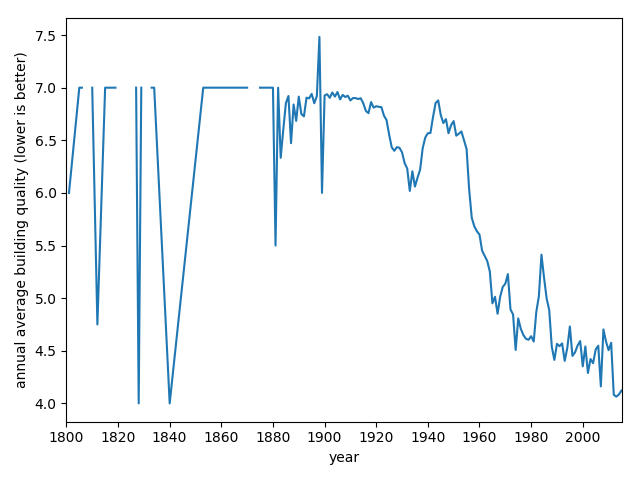

In [234]:
plt.subplots()
x = 'yearbuilt'; y = 'buildingqualitytypeid'
df.groupby([x])[y].mean().plot()
plt.ylabel('annual average building quality (lower is better)'); plt.xlabel('year')
plt.xticks(np.arange(1800, 2020, 20))
plt.tight_layout()
plt.show()

This figure shows how the average building quality changes historically. Note that a lower quality id means a higher quality. We observe that before 1880 there are significantly fewer segments, due to the scarcity of houses in the dataset built in that age. This is perfectly consistent with the log-scale plot above. And the small sample size explains why the y-values before 1880 goes up and down wildly. Into the 20th century, especially after 1950s when most houses were built, the overall trend becomes clear: the average quality gets better and better.

### Plot 4: Scatter plot

<IPython.core.display.Javascript object>


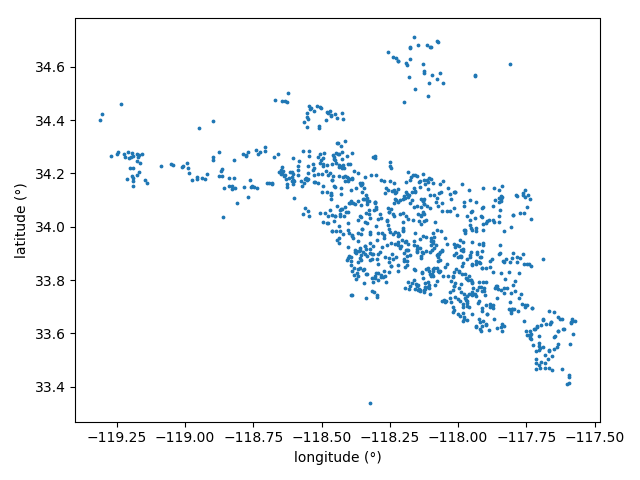

In [257]:
plt.subplots()
sample = rd.sample(range(df.shape[0]), 1000)
x = 'longitude'; y = 'latitude'; z = ' (°)'
plt.scatter(df[x][sample] / 1e6, df[y][sample] / 1e6, s=3)
plt.xlabel(x + z); plt.ylabel(y + z)
plt.tight_layout()
plt.show()

This figure can be viewed as an actual map. The points are the locations of 1000 randomly selected houses. In repeated experiments, the shape of the majority is roughly always a strip from northwest to southeast. This explains the remarkable negative correlation between longitude and latitude we saw in the heatmap.

### Plot 5 & 6: Histogram

<IPython.core.display.Javascript object>


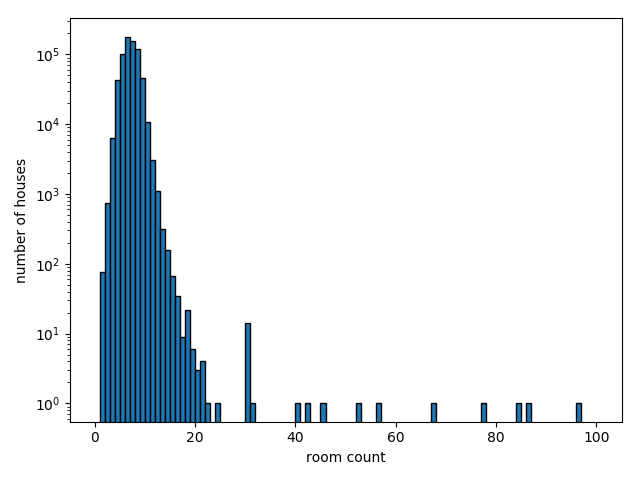

<IPython.core.display.Javascript object>


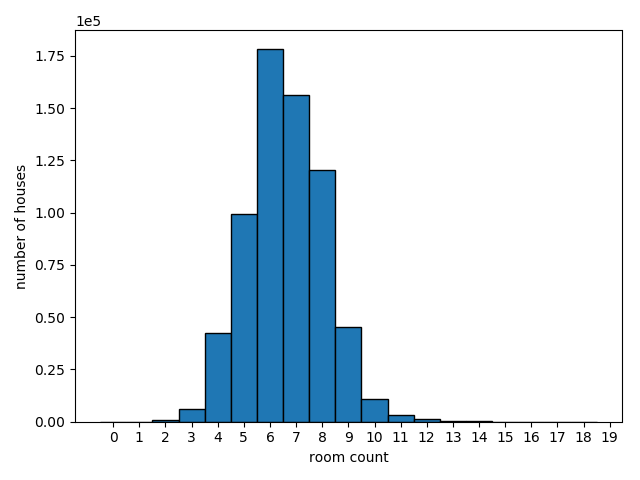

In [265]:
x = 'roomcnt'; y = 'number of houses'

plt.subplots()
plt.hist(df[x].dropna(), bins=100, range=(0, 100), ec='k')
plt.xlabel('room count'); plt.ylabel(y)
plt.yscale('log')
plt.tight_layout()
plt.show()

plt.subplots()
bins = np.arange(20) - 0.5
plt.hist(df[x].dropna(), bins, range=(0, 20), ec='k')
plt.xlabel('room count'); plt.ylabel(y)
plt.xticks(range(20))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.tight_layout()
plt.show()

These figures show the distribution of total room counts. The upper one uses log-scale y-axis so that we could see the existence of some 96-room "castle". The lower one zooms in the interval of room count below 20, with a 10^5 linear scale y-axis. It roughly shows a bell shape, with majority of houses having 3~10 rooms, which is consistent with our expectation from real life experience.

## Task 3: Linear Regression

To build a linear regression model, the ground truth of logerrors should be merged with feature set first. A heatmap is computed here to give some insight into what might be more related to the logerror. Unfortunately no remarkable correlation exist between logerror and any feature.

In [276]:
train = pd.read_csv('train_2016_v2.csv', low_memory=False)
dflr = pd.merge(df, train, on='parcelid')

In [277]:
lrcor = dflr.corr()

<IPython.core.display.Javascript object>


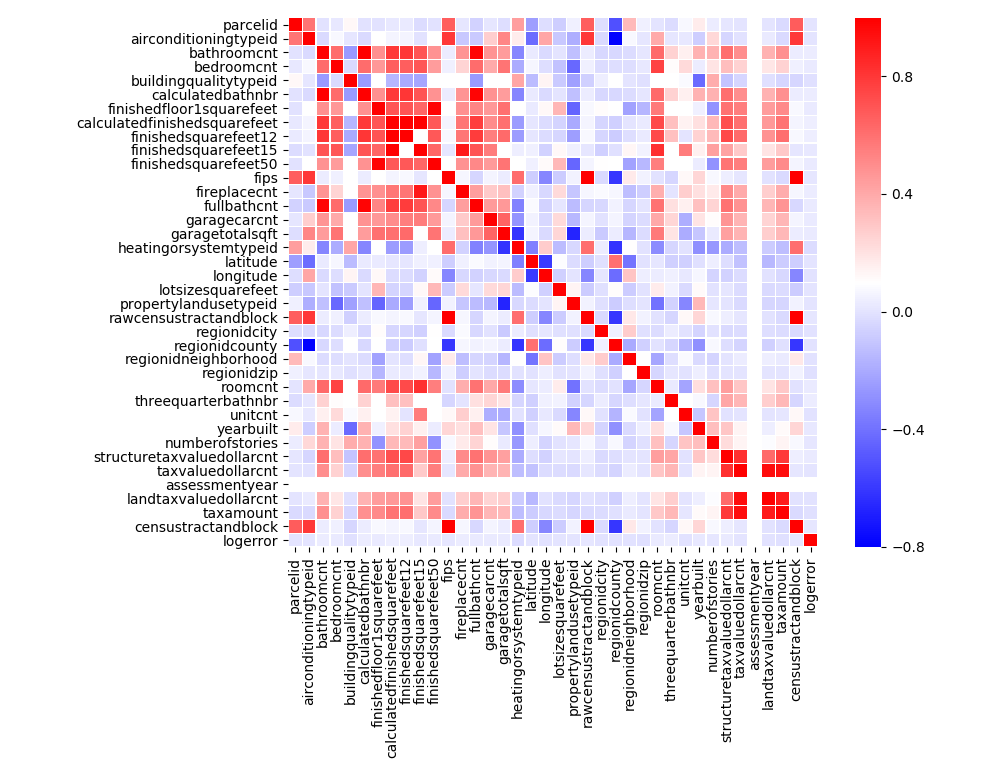

In [38]:
plt.subplots()
sns.heatmap(lrcor, cmap='bwr', xticklabels=True, yticklabels=True, linewidths=0.1, square=True)
plt.yticks(rotation=0);
plt.xticks(rotation=90);
plt.tight_layout()
plt.show()

In [ ]:
raw = pd.read_pickle('properties_2016.pkl')

### Description

So I want to build a naive model first. I have several criteria:
* Features used in linear regression should be numerical.
* Different features used had better mean different things.
* Features intuitively related to the value of the house have higher priority.

Based on them I selected building quality, total area, room count, year built and tax amount as a first feature set. For missing value I used medians of existing data to fill. Generally I found that median gets better score than mean. Mode is sometimes even better but takes way longer to compute. Normalization of the data is automatically an option I could turn on.

In [299]:
features = ['buildingqualitytypeid', 'calculatedfinishedsquarefeet', 'roomcnt', 'yearbuilt', 'taxamount']

reg = linear_model.LinearRegression(normalize=True, n_jobs=-1)
imp = Imputer(strategy='median')
X = imp.fit_transform(dflr[features])
y = dflr['logerror']
reg.fit(X, y)

Xt = imp.fit_transform(raw[features])
yt = reg.predict(Xt)

### How badly does it work?

I used r^2 score to evaluate this model. So it seems bad enough. However, this model received a score of 0.0654079 from Zillow, not that bad.

In [300]:
reg.score(X, y)

0.00287185750901

### Most important variable

I interpret the most important variable as the one with highest absolute coefficient. So according to this, room count is the most important.

In [33]:
reg.coef_

array([  2.92458535e-06,   1.12211347e-05,  -1.20081045e-03,
         6.18248435e-05,  -1.05588921e-06])

## Task 4: Improving Model

Here I try to select a better feature set, based on the ranking of correlations. Unfortunately, the attempts resulted in lower r^2 scores.

In [278]:
lrcor['logerror'].sort_values()

buildingqualitytypeid          -0.009573
taxamount                      -0.006671
regionidzip                    -0.006507
regionidneighborhood           -0.004638
unitcnt                        -0.003983
longitude                      -0.003432
landtaxvaluedollarcnt          -0.003051
regionidcity                   -0.002121
airconditioningtypeid          -0.001585
regionidcounty                  0.000341
propertylandusetypeid           0.001003
heatingorsystemtypeid           0.002549
lotsizesquarefeet               0.004835
parcelid                        0.004837
latitude                        0.004915
taxvaluedollarcnt               0.006508
fips                            0.008363
rawcensustractandblock          0.008376
censustractandblock             0.008892
numberofstories                 0.013075
yearbuilt                       0.017312
finishedsquarefeet15            0.019327
structuretaxvaluedollarcnt      0.022085
roomcnt                         0.023554
finishedsquarefe

In [289]:
features = ['structuretaxvaluedollarcnt', 'roomcnt', 'finishedsquarefeet50', 'garagetotalsqft', 'finishedfloor1squarefeet', 
            'garagecarcnt', 'bedroomcnt', 'fullbathcnt', 'bathroomcnt', 'calculatedbathnbr', 'fireplacecnt', 
            'threequarterbathnbr', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12']
reg = linear_model.LinearRegression(normalize=True, n_jobs=-1)
imp = Imputer(strategy='mean')
X = imp.fit_transform(dflr[features])
y = dflr['logerror']
reg.fit(X, y)

Xt = imp.fit_transform(raw[features])
yt = reg.predict(Xt)

In [290]:
reg.score(X, y)

0.00177680191423

In [288]:
reg.coef_

array([ -1.14447467e-08,  -8.09444856e-04,  -1.17086691e-05,
        -9.03267711e-06,   1.24243054e-05,   2.50114471e-03,
         9.29563813e-04,   4.06653754e-03,  -4.12737318e-02,
         3.63681543e-02,   3.74473628e-03,   3.02169016e-02,
         1.53072514e-06,   7.93259985e-06])

So I tried to build another set with more intuitively related features. It gets a better r^2 score, but worse Zillow score: 0.0784561.

In [363]:
features = ['buildingqualitytypeid', 'calculatedfinishedsquarefeet', 'roomcnt', 'yearbuilt', 'taxamount', 
            'airconditioningtypeid', 'heatingorsystemtypeid', 'lotsizesquarefeet', 'taxvaluedollarcnt', 'latitude', 'longitude', 
            'unitcnt', 'numberofstories']
reg = linear_model.LinearRegression(normalize=True, n_jobs=-1)
imp = Imputer(strategy='most_frequent')
X = imp.fit_transform(dflr[features])
y = dflr['logerror']
reg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=True)

In [364]:
reg.score(X, y)

0.00407747782311

In [361]:
Xt = imp.fit_transform(raw[features])
yt = reg.predict(Xt)

In [362]:
test = pd.read_csv('sample_submission.csv', low_memory=False)
test[[col for col in test if col != 'ParcelId']] = np.matrix([yt] * (test.shape[1] - 1)).T
test.to_csv('med_feat_custom.csv')